# Winter 2023 scRNA-seq analysis module part 1 (loading data and pre-processing)

Please make sure you are using the kernel entitled "Python [conda env:scanpy_2021]" for this exercise.

## scRNA-seq experiments of day 21 reprogramming intermediates cultured under fibroblast condition, naive pluripotent and trophoblast stem cell conditions

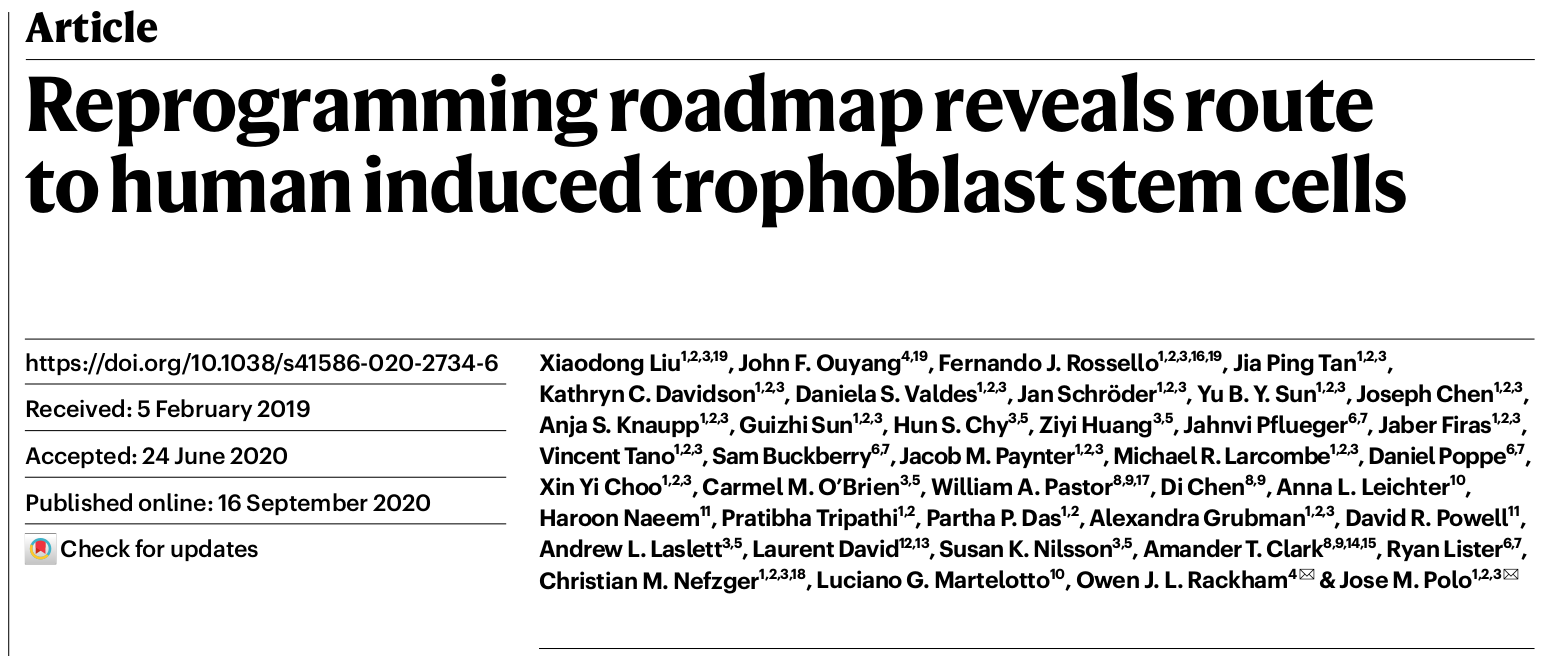

In [1]:
#Article from which the data was obtained
from IPython.display import Image
Image("Liu_et_al_2020.png")

This dataset was downloaded from: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE150637

## Experimental Design

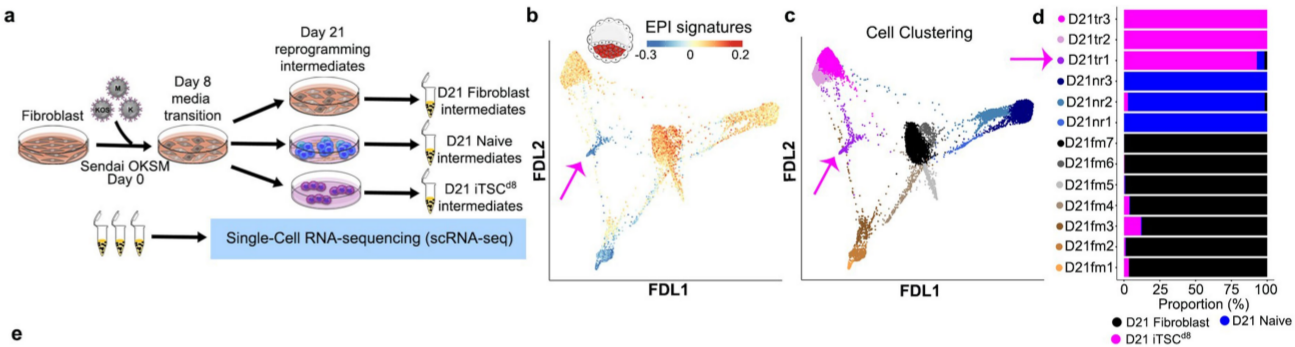

In [2]:
from IPython.display import Image
Image("Experimental_Design.png")

## 1 Import Python packages/libraries to use in analysis¶

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sns
import warnings;
warnings.filterwarnings('ignore');
from gprofiler import GProfiler
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=170, color_map='viridis')  # low dpi (dots per inch) yields small inline figures
sc.logging.print_header()
results_file = './liu2020.h5ad'
results_file_denoised = './liu2020_deno.h5ad'

When we import a package as something else, we are creating a shortcut to easily call the package. For example, import pandas as pd will allow us to type pd when calling a pandas function rather than pandas.

## Starting from a 10X Dataset

Because we opened jupyter lab/notebook from the directory that we made, we only need to enter the path and filename starting from this point. We are going to use Scanpy's "read_10x_mtx" function because we are reading in a 10X mtx file to analyze. We could also start with a matrix generated from FeatureCounts or DESeq2 or any other program using the python package pandas or use a .h5ad file from cell ranger (10X).
​

Here, we are reading in sparse count matrices. If we were going to perform batch correction we would need to convert these to dense representation with the .toarray() function. We create dense matrices as our batch correction method outputs a dense expression matrix, and the data transfer between R and python is currently limited to dense matrices. When sparse batch correction methods are available, and rpy2 is extended to sparse matrices, it is more memory-efficient to keep the data in a sparse format.
​

It should also be noted that the conventions for storing single cell data differ between R (Seurat, or Scater) and python platforms (Scanpy). Scanpy expects the data to be stored in the format (cells x genes), while R platforms expect the transpose of that. As data is typically stored in the format (genes x cells) as in GEO database, we must transpose the data before using it. However, because we are using scanpy's built in 10x data loading, it will transpose the data for us.

The analysis we are doing here is starting from fastq files that have already been run through the 10X CellRanger pipeline. There are a lot of different options available generate the starting matrix but if using the 10X platform most people use CellRanger. To run CellRanger you would do something like:
cellranger count --id Name_of_your_project_or_sample --transcriptome /path_to_your_transcriptome_that_you_are_mapping_to/refdata-gex-GRCh38-2020-A --fastqs=/path_to_where_your_fastq_files_are_located/ --sample=SAMPLE_NAME --jobmode local --localcores=16 --localmem=120 --disable-ui

In [ ]:
adata_TSC = sc.read_10x_mtx('./data/TSC/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading

The command "read_10x_mtx" assumes that the data in question is named matrix.mtx and that there are "features" and "barcodes" .tsv files

In [ ]:
adata_TSC

The above shows that we have about 4700 cells and almost 33,000 genes

We can't have duplicate gene names so we need to make sure that they are unique

In [ ]:
adata_TSC.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

In [ ]:
adata_TSC

In [ ]:
adata_HDF1 = sc.read_10x_mtx('./data/HDF1/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading

In [ ]:
adata_HDF1.var_names_make_unique()

In [ ]:
adata_HDF1

In [ ]:
adata_naive = sc.read_10x_mtx('./data/Naive/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading

In [ ]:
adata_naive.var_names_make_unique()

In [ ]:
adata_naive

Now I am going to label all of the observations from each of the separate data sets

In [ ]:
adata_TSC.obs['cell_type'] = 'TSC'

In [ ]:
adata_HDF1.obs['cell_type'] = 'HDF1'
adata_naive.obs['cell_type'] = 'Naive'

In [ ]:
adata_TSC

Now I am going to concetenate the datasets together and start the preprocessing

In [ ]:
adata = adata_TSC.concatenate([adata_HDF1, adata_naive])

In [ ]:
adata

Note this has added a "batch" observation which we can use to integrate the datasets and/or batch correct the data 

## 2 Pre-processing and Visualization

## 2.1 Quality Control

Data quality control can be split into cell QC and gene QC. Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell. It should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration.

Alternatively, preprocessing can be done somewhere else (such as in R) and then loaded into scanpy. If this is your situation, skip this portion. You can also freeze the raw data at any point if you want to come back to it. Set the .raw attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object returned by sc.pp.log1p.

Log transforming the data in one simple way to "variance-stabilize" your data to adjust the data so that the influence of gene expression magnitude on gene variance.

In [ ]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

Citing from “Simple Single Cell” workflows (Lun, McCarthy & Marioni, 2017):

High proportions of mitochondrial reads are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

In [ ]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

In [ ]:
adata.obs.head()

Scanpy has a "cheat" command called "pp.calculate_qc_metrics()" that we could also use instead of doing all the calculations we did above

In [ ]:
#first we need to make a copy so we don't write anything in our Anndata
adata_qcTest = adata.copy()
sc.pp.calculate_qc_metrics(adata_qcTest, inplace=True)

In [ ]:
#check to see we got the same numbers as our "manual" calculations above:
adata_qcTest.obs.head()

Now lets use a violin plot to take a look at the quality of our data

In [ ]:
sc.pl.violin(adata, ['n_genes', 'n_counts'],jitter=0.4)
sc.pl.violin(adata, ['percent_mito'],jitter=0.4)

The plots show the counts per cell and the fraction of mitochondrial reads (MT frac) for most cells are still far below 20-25%, which is the typical filtering thresholds.

In [ ]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='percent_mito')
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='percent_mito')

By looking at plots of the number of genes versus the number of counts with MT fraction information, we can assess whether there are cells with unexpected summary statistics. It is important here to look at these statistics jointly. For example, there is a cloud of points with many counts, but few genes. Our first instinct would be to filter out these as "dying" outliers, however this should only be done if they show high MT fraction. In this case we should probably filter out the cells with very few genes as these may be difficult to annotate later. This will be true for the initial cellular density between 1000-4000 counts and < ~500 genes.

It is typical for the main cloud of data points, that cells with lower counts and genes tend to have a higher fraction of mitochondrial counts. These cells are likely under stress or are dying. When apoptotic cells are sequenced, there is less mRNA to be captured in the nucleus, and therefore fewer counts overall, and thus a higher fraction of counts fall upon mitochondrial RNA. If cells with high mitochondrial activity were found at higher counts/genes per cell, this would indicate biologically relevant mitochondrial activity.

In [ ]:
#Thresholding decision: counts
p3 = sns.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']<10000], kde=False, bins=60)
plt.show()

p5 = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']>25000], kde=False, bins=60)
plt.show()

Histograms of the number of counts per cell show that there is a groups of cells with fewer than 1,500 counts. These are likely uninformative given the overall distribution of counts. This may be cellular debris found in droplets.

On the upper end of counts, we see just a few cells with counts over 50,000.

In [ ]:
#Thresholding decision: genes
p6 = sns.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sns.distplot(adata.obs['n_genes'][adata.obs['n_genes']<2500], kde=False, bins=60)
plt.show()

It looks like our data has a small population of cells with low gene counts. Given these plots, and the plot of genes vs counts above, we decide to filter out cells with fewer than 1500 genes expressed. Below this we are likely to find dying cells or empty droplets with ambient RNA. Looking above at the joint plots, we see that we filter out the main density of low gene cells with this threshold

In general it is a good idea to be permissive in the early filtering steps, and then come back to filter out more stringently when a clear picture is available of what would be filtered out. This is available after visualization/clustering. For demonstration purposes we stick to a simple (and slightly more stringent) filtering here.

In [ ]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 1500)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 50000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['percent_mito'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 1500)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

In [ ]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 15 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=30)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Genes are also filtered if they are not detected in at least 30 cells. This reduces the dimensions of the matrix by removing 0 count genes and genes which are not sufficiently informative of the dataset. 30 is not a magic number and should be adjusted down or up depending on how many cells are in your dataset.

## 2.2 Normalization

Each count in a count matrix represents the successful capture, reverse transcription and sequencing of a molecule of cellular mRNA. Count depths for identical cells can differ due to the variability inherent in each of these steps. Thus, when gene expression is compared between cells based on count data, any difference may have arisen solely due to sampling effects. Normalization addresses this issue by e.g. scaling count data to obtain correct relative gene expression abundances between cells.

Scanpy has a builtin command (scanpy.pp.normalize_total) which normalizes the counts per cell. If we choose target_sum=1e6, this is CPM normalization. CPM normalization is the most commonly used normalization protocol and is also referred to as “counts per million”. This protocol comes from bulk expression analysis and normalizes count data using a so-called size factor proportional to the count depth per cell. Variations of this method scale the size factors with different factors of 10, or by the median count depth per cell in the dataset. CPM normalization assumes that all cells in the dataset initially contained an equal number of mRNA molecules and count depth differences arise only due to sampling. If target_sum=None, after normalization, each observation (cell) has a total count equal to the median of total counts for observations (cells) before normalization 

If exclude_highly_expressed=True, very highly expressed genes are excluded from the computation of the normalization factor (size factor) for each cell. This is meaningful as these can strongly influence the resulting normalized values for all other genes [Weinreb17]

We will use this normalization for our data today because we have limited cellular variability in our data and due to the time and effort it takes to set up SCRAN, but it is probably not the best method to use.

**Important: Before normalizing the data, we ensure that a copy of the raw count data is kept in a separate AnnData object. This allows us to use methods downstream that require this data as input.**

In [ ]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [ ]:
#Normalize the data and log transform it
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

In [ ]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

The count data has been normalized and log-transformed with an offset of 1. The latter is performed to normalize the data distributions. The offset of 1 ensures that zero counts map to zeros. We keep this data in the '.raw' part of the AnnData object as it will be used to visualize gene expression and perform statistical tests such as computing marker genes for clusters.

## 2.3 Batch Correction

To take a look at the data before we correct for any batch effects we could do something like below:

In [ ]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=30, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch'], alpha=0.5, size=25)

Batch correction is performed to adjust for batch effects from the different samples that you might load together. Our dataset contains three different conditions applied to the same starting cells that are then being combined together so we want to correct for any batch effects. As the batch effect from samples are often overlapping, correcting for this batch effect will also partially regress out differences between regions. We allow for this to optimally cluster the data. This approach can also be helpful to find differentiation trajectories, but we revert back to non-batch-corrected data for differential testing and computing marker genes.

Regression batch correction essentially assumes that each batch must have the same average gene expression across all cells and removes the difference (this can over-correct your data).

Note that ComBat batch correction requires a dense matrix format as input (which is already the case in this example).

If we wanted to batch correct we would perform the below:

In [ ]:
# ComBat batch correction
sc.pp.combat(adata, key='batch')
#where "batch" is what want to correct for. We set this up when we load the data.

In [ ]:
adata.obs

In [ ]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=30, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch'], alpha=0.5, size=25)

From Li et al. 2020 "Although the Regress_Out and ComBat algorithms are both based on linear regression, we noticed the superiority of the ComBat method compared to the Regress_Out method in terms of the batch-correction performance and the computing efficiency (Figs. 1, 2, S9). The Regress_Out algorithm uses a general linear model (GLM) to regress out unwanted sources of variation in the expression matrix. The coefficient for each batch block is estimated by fitting the GLM and is then set to zero to remove the corresponding batch effect. The ComBat algorithm uses the same strategy but performs an empirical Bayes (EB) framework to adjust the expression matrix for batch correction. The EB framework is usually designed to shrink gene variances and remove the inferred batch effect by fitting a Bayesian model. ComBat first standardizes all gene expression values across cells and fits the data into a standard distribution Bayesian model. Then, it can infer the batch effects using the estimated model and adjust the gene variances (Johnson et al. 2007a; Leek 2014). Due to the empirical Bayesian shrinkage of the blocking coefficient estimates, the ComBat algorithm is quite robust when processing diverse batches, which is also reflected in our analysis in both the MCA and TM data sets (Figs. 1, 2)."

Note ComBat batch correction can produce negative expression values. One can either set all negative values to 0 or force zeros pre-batch-correction to remain zero post-batch-correction.

### Integration

Sometimes batch correction isn't enough...
There are also several data integration tools that you can and should use to integrate single cell data from multiple experiments such as bbknn (https://doi.org/10.1093/bioinformatics/btz625) or Harmony (Nature Methods <https://doi.org/10.1038/s41592-019-0619-0>). Scanpy has the "ingest" (scanpy.tl.ingest) built into the API but also has bbknn, Harmony, and mutual nearest neighbor in the external API (pp.bbknn(adata[, batch_key, approx, metric, …]) and (pp.harmony_integrate(adata, key[, basis, …]) and (pp.mnn_correct(*datas[, var_index, …])

Recently, I have been using SCVI https://scvi-tools.org/

In [ ]:
'''
import scvi
import torch

scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["batch"])
    
model = scvi.model.SCVI(adata)

model.train()

#saving the model
model.save("model_for_adata/")

#get the model outputs
latent = model.get_latent_representation()

adata.obsm["X_scVI"] = latent
'''

## 2.4 Highly Variable Genes

We extract highly variable genes (HVGs) to further reduce the dimensionality of the dataset and include only the most informative genes. Genes that vary substantially across the dataset are informative of the underlying biological variation in the data. As we only want to capture biological variation in these genes, we select highly variable genes after normalization and batch correction. **HVGs are used for clustering, trajectory inference, and dimensionality reduction/visualization, while the full data set is used for computing marker genes, differential testing, cell cycle scoring, and visualizing expression values on the data.**

Keep in mind that any given tissue or cell type expresses 11,000 to 13,000 genes, of which 3,000 to 5,000 have a cell type expression pattern, whereas the remaining genes are ubiquitously expressed.

NOTE: The below command expects log data (except when the flavor='seurat_v3') is used.

In [ ]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=5, min_disp=0.5)

In [ ]:
sc.pl.highly_variable_genes(adata)

The plots show how the data was normalized to select highly variable genes irrespective of the mean expression of the genes unless  you set a maximum. This is achieved by using the index of dispersion which divides by mean expression, and subsequently binning the data by mean expression and selecting the most variable genes within each bin.

Highly variable gene information is stored automatically in the adata.var['highly_variable'] field. The dataset now contains:

- a 'counts' layer with count data
- log-normalized data in adata.raw
- highly variable gene annotations in adata.var['highly_variable']

The HVG labels will be used to subselect genes for clustering and trajectory analysis.

In [ ]:
adata

Alternatively, we could use the standard technique for the extraction of highly variable genes from the 10X genomics preprocessing software CellRanger. Typically between 1000 and 5000 genes are selected. Here, we extract the top 4000 most variable genes for further processing. If particular genes of importance are known, one could assess how many highly variable genes are necessary to include all, or the majority, of these

In [ ]:
'''sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))'''

To take a look at how many genes we ended up with using the filter above we can do:

In [ ]:
adata.var.highly_variable.sum()

And to see how many genes are not HVG:

In [ ]:
(~adata.var.highly_variable).sum()

A more customized way to find highly variable genes would be to use genes that are variable in each of the cell types (batches) that are in our dataset

In [ ]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=5, min_disp=0.5, batch_key = 'batch')
var_genes_all = adata.var.highly_variable

print("Highly variable genes: %d"%sum(var_genes_all))

print("Highly variable genes intersection: %d"%sum(adata.var.highly_variable_intersection))

print("Number of batches where gene is variable:")
print(adata.var.highly_variable_nbatches.value_counts())

var_genes_batch = adata.var.highly_variable_nbatches > 0

In [ ]:
print("Any batch var genes: %d"%sum(var_genes_batch))
print("All data var genes: %d"%sum(var_genes_all))
print("Overlap: %d"%sum(var_genes_batch & var_genes_all))
print("Variable genes in all batches: %d"%sum(adata.var.highly_variable_nbatches == 3))
print("Overlap batch instersection and all: %d"%sum(var_genes_all & adata.var.highly_variable_intersection))

In [ ]:
var_select = adata.var.highly_variable_nbatches > 1
var_genes = var_select.index[var_select]
len(var_genes)

Here we would save our data so we could reload it in the next section to continue on. However, due to file size limits on student Datahub accounts we cannot save out the .h5ad file because it'll be about 2.5GB big! The instructors have created an .h5ad file that you can read in for the next notebook.

In [ ]:
### adata.write_h5ad('./data/adata_section1_02072023.h5ad')

# Break time and PBMC analysis